# Analyse ROMY Events

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sixdegrees.sixdegrees import sixdegrees

from sixdegrees.plots.plot_velocities import plot_velocities

## Configurations

Here we load the data from a local mseed file (data_source = "mseed_file"). All parameters for the processing and plotting are set hereafter in the configuration dictionary.

In [8]:
config = {
    # Required time window parameters
    'tbeg': "2023-09-08 22:13:00",  # Start time
    'tend': "2023-09-08 23:00:00",  # End time

    # event
    'origin_time': "2023-09-08 22:11:00",
    'magnitude': 6.8,

    # Station coordinates (required)
    'station_lon': 11.275476,  # BSPF longitude
    'station_lat': 48.162941,    # BSPF latitude
    
    # SEED identifiers
    'seed': "XX.ROMY..",     # Default seed ID
    'rot_seed': ["XX.ROMY..BJZ", "XX.ROMY..BJN", "XX.ROMY..BJE"], # "BW.ROMY.30.BJ*",  # Rotation sensor seed ID
    'tra_seed': ["XX.ROMY..BHZ", "XX.ROMY..BHN", "XX.ROMY..BHE"],  # Translation sensor seed ID
    
    # Data source
    'data_source': "mseed_file",  # "fdsn" | "sds" | "mseed_file"

    # Path to local mseed file
    'path_to_mseed_file': "./data/romy_eventM6.8.mseed",  # "./data/eventM62_6c.mseed",

    # Path configurations
    'workdir': "./",            # Working directory
    'path_to_data_out': "./output/",  # Output directory

    # Project information
    'project': "ROMY_Analysis",  # Project name
    
    # Backazimuth calculation parameters
    'baz_step': 1,               # Step size for backazimuth search in degrees
    'twin_sec': 30,          # Window length in seconds
    'twin_overlap': 0.5,  # Window overlap in seconds
    'cc_threshold': 0.75,        # Cross-correlation threshold

    # Filter parameters
    'fmin': 0.02,               # Minimum frequency for filtering
    'fmax': 0.2,                # Maximum frequency for filtering
    
    # Optional parameters
    'verbose': True,            # Print detailed information
}

Setup a sixdegrees object

In [9]:
sd = sixdegrees(conf=config)

Store the configuration as a pickle file

In [10]:
# sd.store_as_pickle(config, "./event_configs/"+f"M{str(config['magnitude']).replace('.','')}_{config['tbeg'][:10].replace('-','')}")

Get key information about the event

In [11]:
ev = sd.get_event_info(
    origin_time=config['origin_time'],
    base_catalog="USGS",
    magnitude=config['magnitude']
)

Found event:
Origin time: 2023-09-08T22:11:01.405000Z
Magnitude: 6.8 mww
Location: 31.058°N, -8.385°E
Depth: 19.0 km
Epicentral Distance: 2526.01 km
Epicentral Distance: 22.7°
Backazimuth: 228.40°


This will load the data from the data source:
- local mseed file
- local sds system
- fdsn (online)

and trim it to the time window

In [12]:
sd.load_data(config['tbeg'], config['tend'])

-> fetching XX.ROMY..BHZ data from mseed file
-> fetching XX.ROMY..BHN data from mseed file
-> fetching XX.ROMY..BHE data from mseed file
3 Trace(s) in Stream:
XX.ROMY..BHZ | 2023-09-08T22:12:58.989999Z - 2023-09-08T23:00:00.989999Z | 20.0 Hz, 56441 samples
XX.ROMY..BHN | 2023-09-08T22:12:58.990000Z - 2023-09-08T23:00:00.990000Z | 20.0 Hz, 56441 samples
XX.ROMY..BHE | 2023-09-08T22:12:58.990000Z - 2023-09-08T23:00:00.990000Z | 20.0 Hz, 56441 samples
-> fetching XX.ROMY..BJZ data from mseed file
-> fetching XX.ROMY..BJN data from mseed file
-> fetching XX.ROMY..BJE data from mseed file
3 Trace(s) in Stream:
XX.ROMY..BJZ | 2023-09-08T22:12:59.011600Z - 2023-09-08T23:00:01.011600Z | 20.0 Hz, 56441 samples
XX.ROMY..BJN | 2023-09-08T22:12:58.999400Z - 2023-09-08T23:00:00.999400Z | 20.0 Hz, 56441 samples
XX.ROMY..BJE | 2023-09-08T22:12:59.036600Z - 2023-09-08T23:00:00.986600Z | 20.0 Hz, 56440 samples


Ensure that all traces of stream have the same sample size

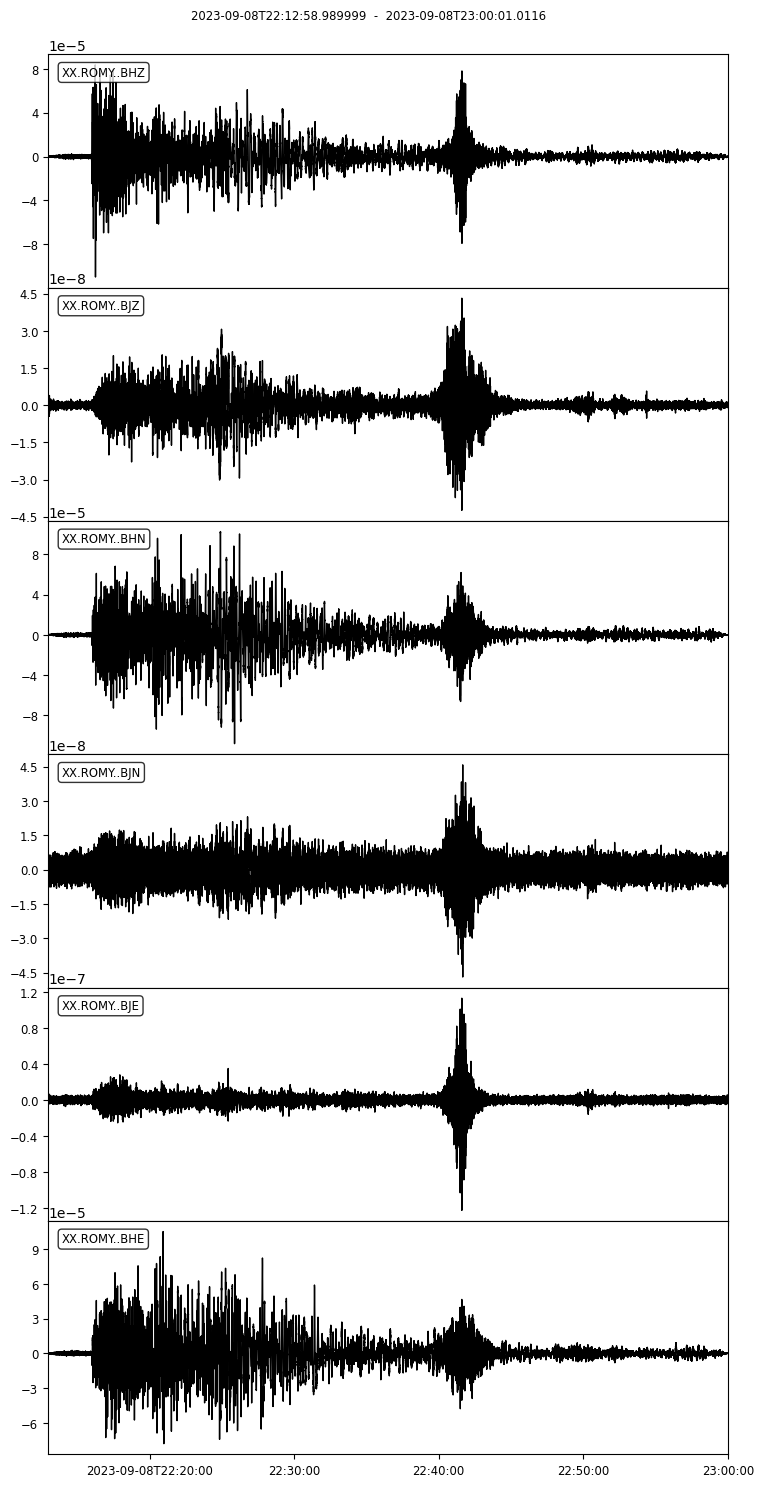

In [13]:
sd.st.plot(equal_scale=False);

In [14]:
sd.trim_stream(set_common=True, set_interpolate=False)

 -> stream size inconsistent: [56441, 56441, 56441, 56441, 56441, 56440]
  -> adjusted: [56440, 56440, 56440, 56440, 56440, 56440]


## Analysis

Frequency band to filter (this is applied to the stream object after being reset to raw stream)

In [15]:
sd.filter_data(fmin=config['fmin'], fmax=config['fmax'], output=False)

Apply polarity correction if needed. This is applied to the stream object that is processed. If raw is True, the polarity correction is applied to the raw stream too.

In [16]:
sd.polarity_stream(pol_dict={"HZ": -1, "JZ": 1}, raw=True)

-> polarity for channel HZ changed from 1 to -1


### Analyse phase velocities

In [17]:
# Compute Love wave velocities
love_velocities = sd.compute_velocities(
    wave_type='love',
    win_time_s=config['twin_sec'],
    overlap=0.5,
    cc_threshold=config['cc_threshold'],
    method='odr',  # 'odr' | 'ransac'
    baz=ev['backazimuth']  # theoretical backazimuth (optional)
)

# Compute Rayleigh wave velocities
rayleigh_velocities = sd.compute_velocities(
    wave_type='rayleigh',
    win_time_s=config['twin_sec'],
    overlap=0.5,
    cc_threshold=config['cc_threshold'],
    method='odr',  # 'odr' | 'ransac'
    baz=ev['backazimuth']  # theoretical backazimuth (optional)
)

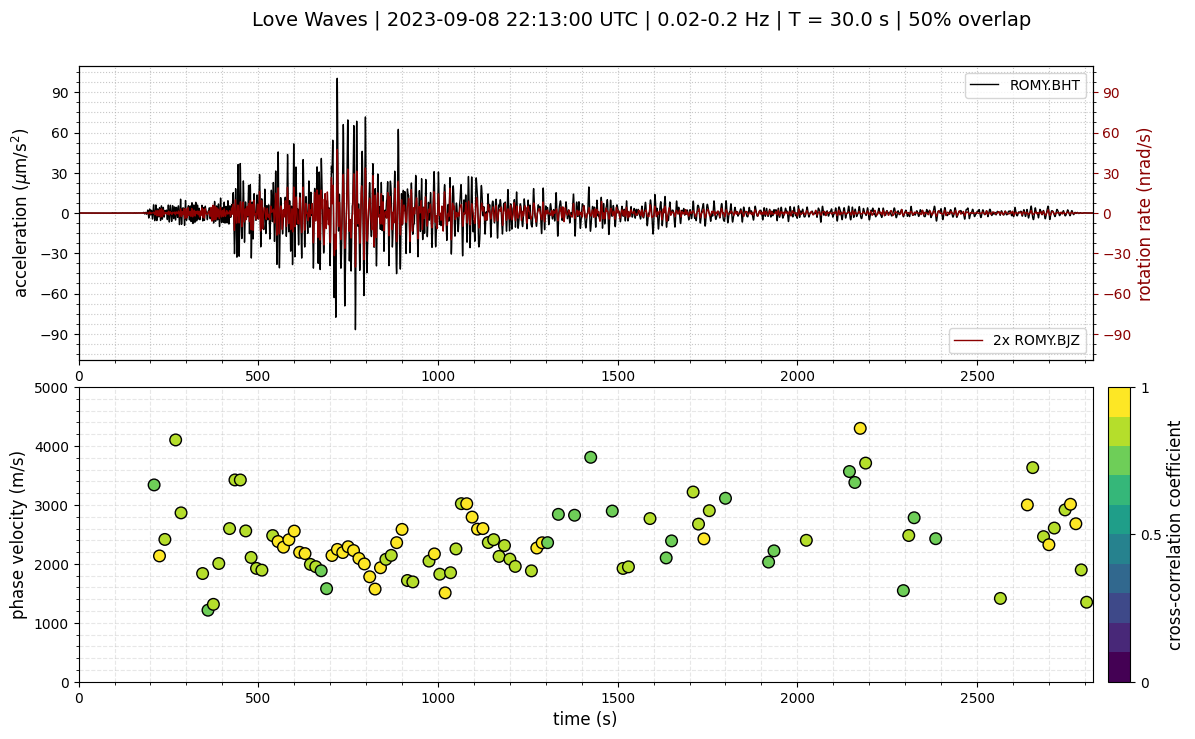

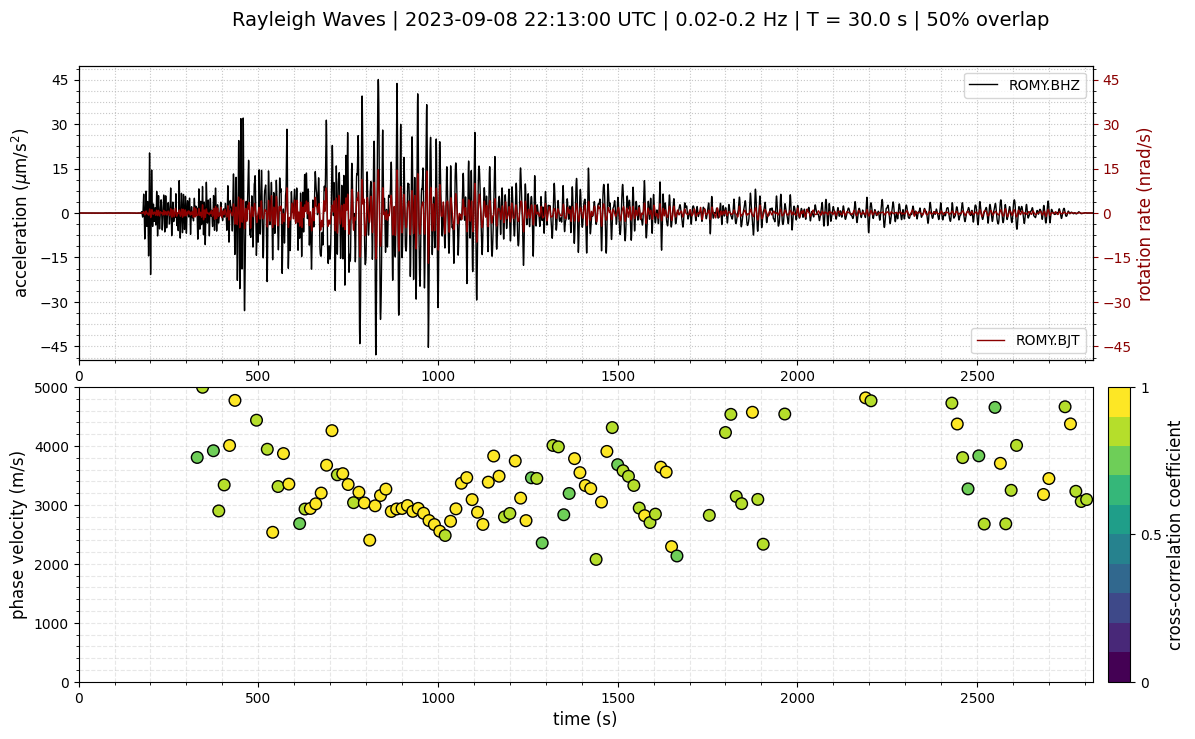

In [24]:
# Plot results
fig = plot_velocities(
    sd,
    velocity_results=love_velocities,
    vmax=5000,  # optional
    minors=True # optional
)

# Plot results
fig = plot_velocities(
    sd,
    velocity_results=rayleigh_velocities,
    vmax=5000,  # optional
    minors=True # optional
)

### Check velocities in time windows

Estimating backazimuth and velocities in time windows rather than assuming the backazimuth is constant.


In [ ]:
# Step 1: Get the rotation and translation streams (use raw=True to get unfiltered data)
rot_stream = sd.get_stream("rotation", raw=True)
tra_stream = sd.get_stream("translation", raw=True)

# Step 2: Compute backazimuth results first
# This is required before calling compute_velocities_optimized
baz_results_love = sd.compute_backazimuth(
    wave_type='love',  # or 'rayleigh'
    baz_step=config['baz_step'],
    baz_win_sec=config['twin_sec'],
    baz_win_overlap=config['twin_overlap'],
    rotation_data=rot_stream,
    translation_data=tra_stream,
    cc_threshold=config['cc_threshold'],
    out=True  # Return results dictionary
)

# Step 3: Compute velocities using the optimized method
love_velocities_win1 = sd.compute_velocities_optimized(
    rotation_data=rot_stream,
    translation_data=tra_stream,
    wave_type='love',  # or 'rayleigh'
    baz_results=baz_results_love,
    baz_mode='mid',  # 'mid' or 'max' - use 'mid' for median backazimuth, 'max' for maximum correlation
    method='odr',  # 'odr' | 'ransac' | 'theilsen'
    cc_threshold=config['cc_threshold'],
    r_squared_threshold=0.0,  # Minimum R-squared threshold for regression quality
    zero_intercept=True,  # Force intercept to be zero
    plot=False  # Set to True to plot regression results
)

  Final backazimuths: 360 points
  Correlation array shape: (360, 187)
  Number of windows: 187
Fast backazimuth estimation: love waves
  Coarse search: 10° steps
  Fine search: 1° steps
  Windows: 187
 > using love waves for backazimuth estimation ...
  Stage 1: Coarse search with 10° steps (36 points)
  Processing window 0: indices 0-600
    Window 0: Best coarse baz = 50.0° (cc = 0.248)
  Processing window 1: indices 300-900
    Window 1: Best coarse baz = 10.0° (cc = 0.215)
  Processing window 2: indices 600-1200
    Window 2: Best coarse baz = 0.0° (cc = 0.188)
ODR Results: slope=1821.409452, R²=0.5734
ODR Results: slope=1944.742718, R²=0.6869
ODR Results: slope=2542.750435, R²=0.5901
ODR Results: slope=2056.879457, R²=0.6077
ODR Results: slope=1947.943352, R²=0.6361
ODR Results: slope=2008.405188, R²=0.6601
ODR Results: slope=2161.060510, R²=0.8246
ODR Results: slope=1934.084899, R²=0.7651
ODR Results: slope=1388.980857, R²=0.7192
ODR Results: slope=1979.442053, R²=0.7424
ODR Res

KeyError: 'baz'

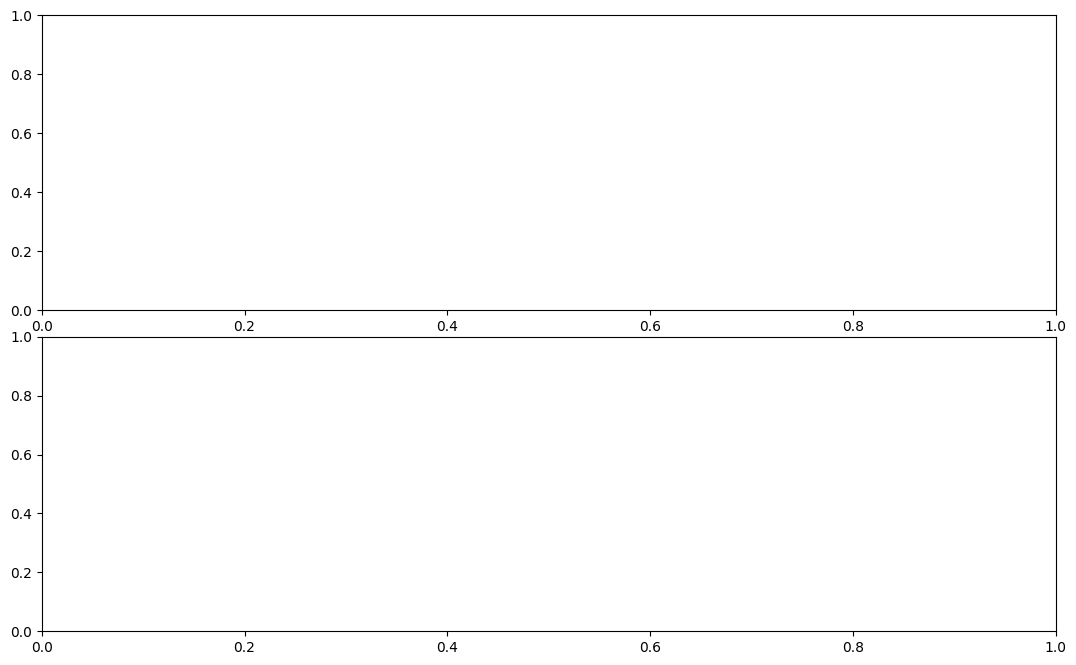

In [34]:
# Plot results
fig = plot_velocities(
    sd,
    velocity_results=love_velocities_win1,
    vmax=5000,  # optional
    minors=True, # optional
)


For reference, here is the plot with the theoretical backazimuth:

In [ ]:
love_velocities_win2 =sd.compute_velocities_in_windows(
    wave_type='love',
    win_time_s=config['twin_sec'],
    overlap=0.5,
    cc_threshold=0.8,
    method='odr',  # 'odr' | 'ransac'
    baz=ev['backazimuth']  # theoretical backazimuth (optional)
)

/tmp/ipykernel_573361/73270533.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


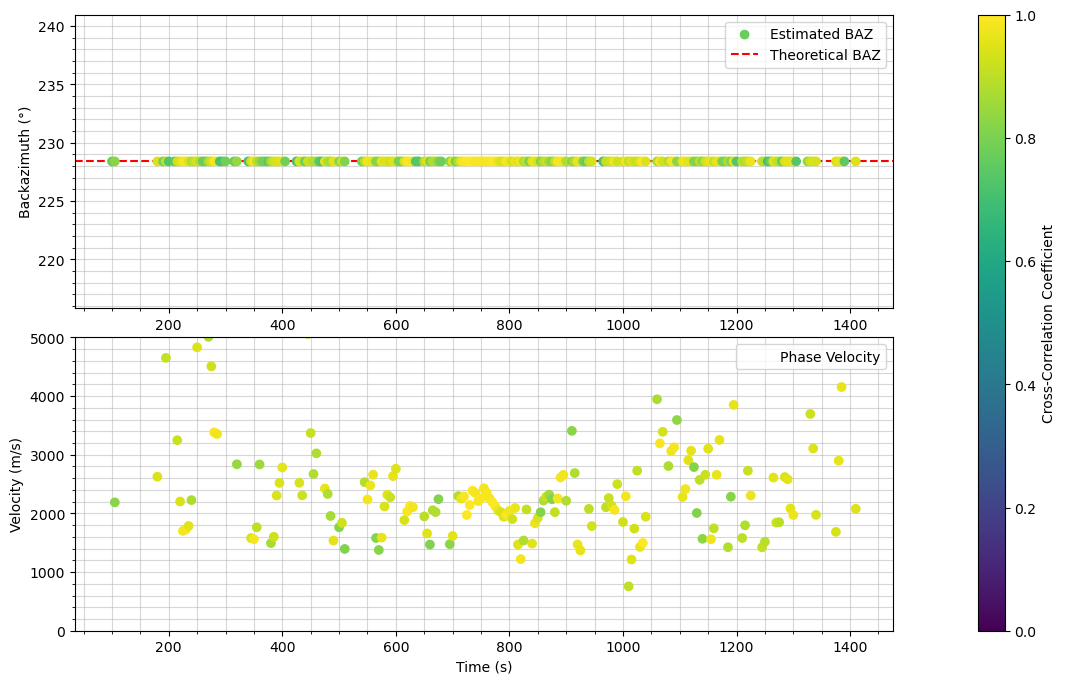

In [ ]:
fig = plot_love_velocities_win(love_velocities_win2, cc_threshold=0.7)

To see the difference in velocities between the two appraoches

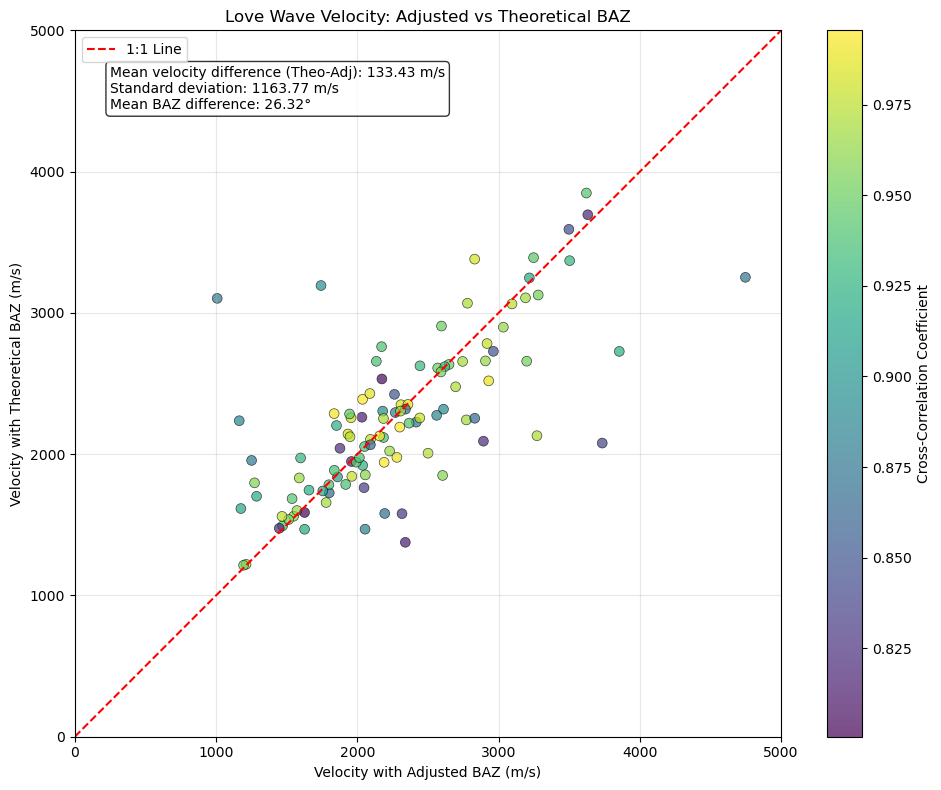

In [ ]:
def plot_velocity_window_comparison(results1, results2, cc_threshold=0.7, vmax=5000):
    """
    Create a scatter plot comparing velocities from two different window approaches.
    
    Parameters:
    -----------
    results1 : dict
        Results dictionary from compute_velocities_in_windows with adjusted_baz=True
    results2 : dict
        Results dictionary from compute_velocities_in_windows with fixed theoretical baz
    cc_threshold : float
        Minimum cross-correlation coefficient to include in the plot
    vmax : float
        Maximum velocity to display on axes
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object containing the plot
    """
    # Extract velocities and apply threshold
    mask1 = np.array(results1['ccoef']) >= cc_threshold
    mask2 = np.array(results2['ccoef']) >= cc_threshold
    
    # Find common time points (assuming time arrays are the same)
    common_mask = mask1 & mask2
    
    # Extract velocities for common points
    vel1 = np.array(results1['velocity'])[common_mask]
    vel2 = np.array(results2['velocity'])[common_mask]
    cc = np.array(results1['ccoef'])[common_mask]  # Use CC from first result
    baz_diff = np.abs(np.array(results1['backazimuth'])[common_mask] - 
                      np.array(results2['backazimuth'])[common_mask])
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create scatter plot
    sc = ax.scatter(vel1, vel2, c=cc, cmap='viridis', 
                   alpha=0.7, s=50, edgecolor='k', linewidth=0.5)
    
    # Add colorbar
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Cross-Correlation Coefficient')
    
    # Add identity line
    vals = np.linspace(0, vmax, 100)
    ax.plot(vals, vals, 'r--', label='1:1 Line')
    
    # Set axis limits
    ax.set_xlim(0, vmax)
    ax.set_ylim(0, vmax)
    
    # Add labels and title
    ax.set_xlabel('Velocity with Adjusted BAZ (m/s)')
    ax.set_ylabel('Velocity with Theoretical BAZ (m/s)')
    ax.set_title('Love Wave Velocity: Adjusted vs Theoretical BAZ')
    
    # Add grid and legend
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Set equal aspect ratio
    ax.set_aspect('equal')
    
    # Add statistics
    diff = vel2 - vel1
    mean_diff = np.mean(diff)
    std_diff = np.std(diff)
    mean_baz_diff = np.mean(baz_diff)
    
    stats_text = f"Mean velocity difference (Theo-Adj): {mean_diff:.2f} m/s\n"
    stats_text += f"Standard deviation: {std_diff:.2f} m/s\n"
    stats_text += f"Mean BAZ difference: {mean_baz_diff:.2f}°"
    
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return fig

# Example usage:
fig = plot_velocity_window_comparison(
    love_velocities_win1,  # Results with adjusted backazimuth
    love_velocities_win2,  # Results with theoretical backazimuth
    cc_threshold=0.8,
    vmax=5000
)

/tmp/ipykernel_573361/2875426602.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


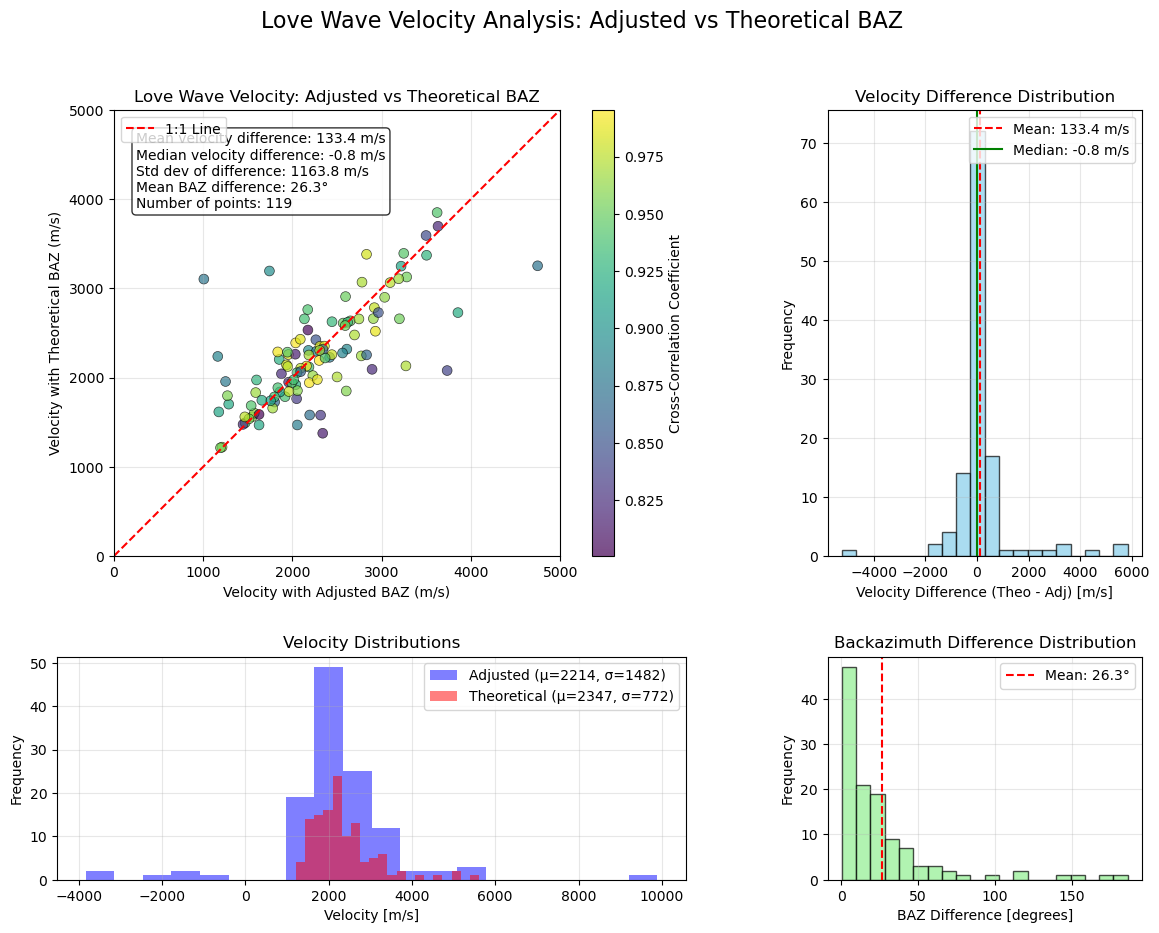

In [ ]:
def plot_velocity_comparison_with_histograms(results1, results2, cc_threshold=0.7, vmax=5000):
    """
    Create a comprehensive comparison of velocities from two different window approaches,
    including scatter plot and histograms.
    
    Parameters:
    -----------
    results1 : dict
        Results dictionary from compute_velocities_in_windows with adjusted_baz=True
    results2 : dict
        Results dictionary from compute_velocities_in_windows with fixed theoretical baz
    cc_threshold : float
        Minimum cross-correlation coefficient to include in the plot
    vmax : float
        Maximum velocity to display on axes
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object containing the plot
    """
    # Extract velocities and apply threshold
    mask1 = np.array(results1['ccoef']) >= cc_threshold
    mask2 = np.array(results2['ccoef']) >= cc_threshold
    
    # Find common time points (assuming time arrays are the same)
    common_mask = mask1 & mask2
    
    # Extract velocities for common points
    vel1 = np.array(results1['velocity'])[common_mask]
    vel2 = np.array(results2['velocity'])[common_mask]
    cc = np.array(results1['ccoef'])[common_mask]  # Use CC from first result
    baz_diff = np.abs(np.array(results1['backazimuth'])[common_mask] - 
                      np.array(results2['backazimuth'])[common_mask])
    
    # Calculate differences and remove NaN values
    vel_diff = vel2 - vel1
    valid_mask = ~np.isnan(vel_diff) & ~np.isnan(baz_diff)
    
    vel1 = vel1[valid_mask]
    vel2 = vel2[valid_mask]
    vel_diff = vel_diff[valid_mask]
    baz_diff = baz_diff[valid_mask]
    cc = cc[valid_mask]
    
    # Create figure with gridspec
    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(2, 2, width_ratios=[2, 1], height_ratios=[2, 1], 
                         hspace=0.3, wspace=0.3)
    
    # Main scatter plot
    ax_scatter = fig.add_subplot(gs[0, 0])
    sc = ax_scatter.scatter(vel1, vel2, c=cc, cmap='viridis', 
                          alpha=0.7, s=50, edgecolor='k', linewidth=0.5)
    
    # Add identity line
    vals = np.linspace(0, vmax, 100)
    ax_scatter.plot(vals, vals, 'r--', label='1:1 Line')
    
    # Set axis limits
    ax_scatter.set_xlim(0, vmax)
    ax_scatter.set_ylim(0, vmax)
    
    # Add labels and title
    ax_scatter.set_xlabel('Velocity with Adjusted BAZ (m/s)')
    ax_scatter.set_ylabel('Velocity with Theoretical BAZ (m/s)')
    ax_scatter.set_title('Love Wave Velocity: Adjusted vs Theoretical BAZ')
    
    # Add grid and legend
    ax_scatter.grid(True, alpha=0.3)
    ax_scatter.legend()
    
    # Set equal aspect ratio
    ax_scatter.set_aspect('equal')
    
    # Add colorbar
    cbar = plt.colorbar(sc, ax=ax_scatter)
    cbar.set_label('Cross-Correlation Coefficient')
    
    # Histogram of velocity differences
    ax_hist_diff = fig.add_subplot(gs[0, 1])
    if len(vel_diff) > 0:
        ax_hist_diff.hist(vel_diff, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
        mean_diff = np.nanmean(vel_diff)
        median_diff = np.nanmedian(vel_diff)
        ax_hist_diff.axvline(x=mean_diff, color='r', linestyle='--', 
                            label=f'Mean: {mean_diff:.1f} m/s')
        ax_hist_diff.axvline(x=median_diff, color='g', linestyle='-', 
                            label=f'Median: {median_diff:.1f} m/s')
    ax_hist_diff.set_xlabel('Velocity Difference (Theo - Adj) [m/s]')
    ax_hist_diff.set_ylabel('Frequency')
    ax_hist_diff.set_title('Velocity Difference Distribution')
    ax_hist_diff.legend()
    ax_hist_diff.grid(alpha=0.3)
    
    # Histogram of BAZ differences
    ax_hist_baz = fig.add_subplot(gs[1, 1])
    if len(baz_diff) > 0:
        ax_hist_baz.hist(baz_diff, bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
        mean_baz_diff = np.nanmean(baz_diff)
        ax_hist_baz.axvline(x=mean_baz_diff, color='r', linestyle='--', 
                           label=f'Mean: {mean_baz_diff:.1f}°')
    ax_hist_baz.set_xlabel('BAZ Difference [degrees]')
    ax_hist_baz.set_ylabel('Frequency')
    ax_hist_baz.set_title('Backazimuth Difference Distribution')
    ax_hist_baz.legend()
    ax_hist_baz.grid(alpha=0.3)
    
    # Velocity histograms
    ax_hist_vel = fig.add_subplot(gs[1, 0])
    if len(vel1) > 0 and len(vel2) > 0:
        mean_vel1 = np.nanmean(vel1)
        std_vel1 = np.nanstd(vel1)
        mean_vel2 = np.nanmean(vel2)
        std_vel2 = np.nanstd(vel2)
        
        ax_hist_vel.hist(vel1, bins=20, alpha=0.5, color='blue', 
                        label=f'Adjusted (μ={mean_vel1:.0f}, σ={std_vel1:.0f})')
        ax_hist_vel.hist(vel2, bins=20, alpha=0.5, color='red', 
                        label=f'Theoretical (μ={mean_vel2:.0f}, σ={std_vel2:.0f})')
    ax_hist_vel.set_xlabel('Velocity [m/s]')
    ax_hist_vel.set_ylabel('Frequency')
    ax_hist_vel.set_title('Velocity Distributions')
    ax_hist_vel.legend()
    ax_hist_vel.grid(alpha=0.3)
    
    # Add statistics as text
    if len(vel_diff) > 0:
        stats_text = (f"Mean velocity difference: {np.nanmean(vel_diff):.1f} m/s\n"
                     f"Median velocity difference: {np.nanmedian(vel_diff):.1f} m/s\n"
                     f"Std dev of difference: {np.nanstd(vel_diff):.1f} m/s\n"
                     f"Mean BAZ difference: {np.nanmean(baz_diff):.1f}°\n"
                     f"Number of points: {len(vel_diff)}")
    else:
        stats_text = "No valid data points for statistics"
    
    ax_scatter.text(0.05, 0.95, stats_text, transform=ax_scatter.transAxes,
                  verticalalignment='top', bbox=dict(boxstyle='round', 
                                                   facecolor='white', alpha=0.8))
    
    plt.suptitle('Love Wave Velocity Analysis: Adjusted vs Theoretical BAZ', 
                fontsize=16, y=0.98)
    
    plt.tight_layout()
    return fig

# Example usage:
fig = plot_velocity_comparison_with_histograms(
    love_velocities_win1,  # Results with adjusted backazimuth
    love_velocities_win2,  # Results with theoretical backazimuth
    cc_threshold=0.7,
    vmax=5000
)
plt.show()

### Compare RANSAC and ODR Regression

Here we compare the RANSAC and ODR Regression methods for the computation of the phase velocities.

In [ ]:
# Compute Love wave velocities
love_velocities_ransac = sd.compute_velocities(
    wave_type='love',
    win_time_s=config['twin_sec'],
    overlap=0.5,
    cc_threshold=config['cc_threshold'],
    method='ransac',  # 'odr' | 'ransac'
    baz=ev['backazimuth']  # theoretical backazimuth (optional)
)

# Compute Rayleigh wave velocities
rayleigh_velocities_ransac = sd.compute_velocities(
    wave_type='rayleigh',
    win_time_s=config['twin_sec'],
    overlap=0.5,
    cc_threshold=config['cc_threshold'],
    method='ransac',  # 'odr' | 'ransac'
    baz=ev['backazimuth']  # theoretical backazimuth (optional)
)

# Compute Love wave velocities
love_velocities_odr = sd.compute_velocities(
    wave_type='love',
    win_time_s=config['twin_sec'],
    overlap=0.5,
    cc_threshold=config['cc_threshold'],
    method='odr',  # 'odr' | 'ransac'
    baz=ev['backazimuth']  # theoretical backazimuth (optional)
)

# Compute Rayleigh wave velocities
rayleigh_velocities_odr = sd.compute_velocities(
    wave_type='rayleigh',
    win_time_s=config['twin_sec'],
    overlap=0.5,
    cc_threshold=config['cc_threshold'],
    method='odr',  # 'odr' | 'ransac'
    baz=ev['backazimuth']  # theoretical backazimuth (optional)
)

/home/andbro/cursorfiles/sixdegrees/sixdegrees.py:3788: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


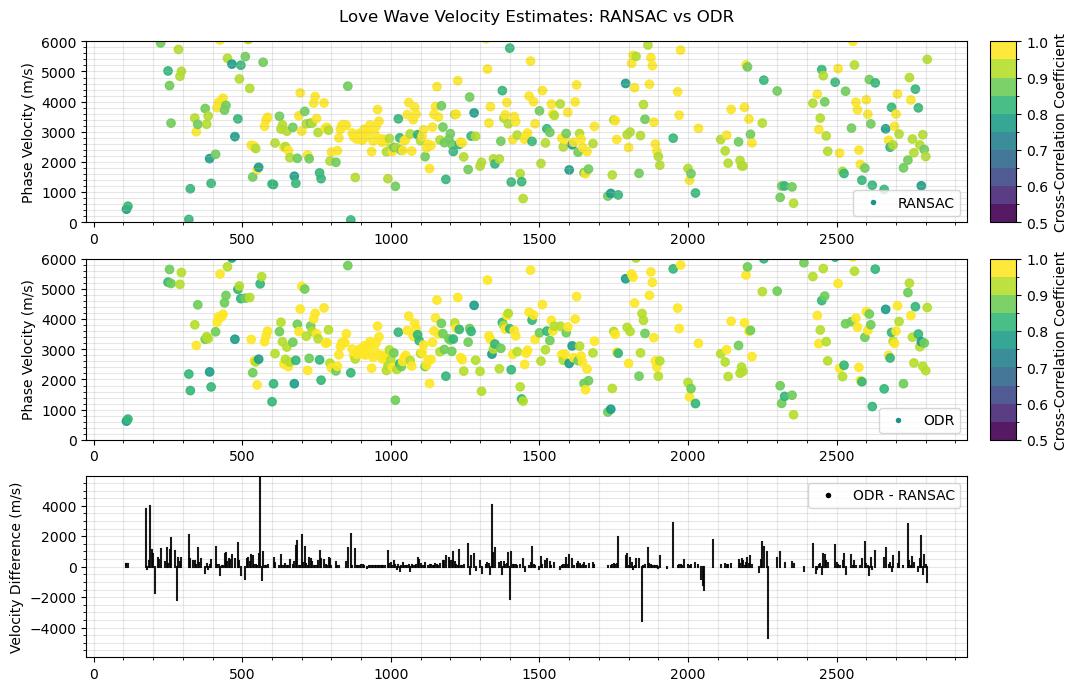

In [ ]:
fig = sd.plot_velocity_method_comparison(rayleigh_velocities_ransac,
                                         rayleigh_velocities_odr)

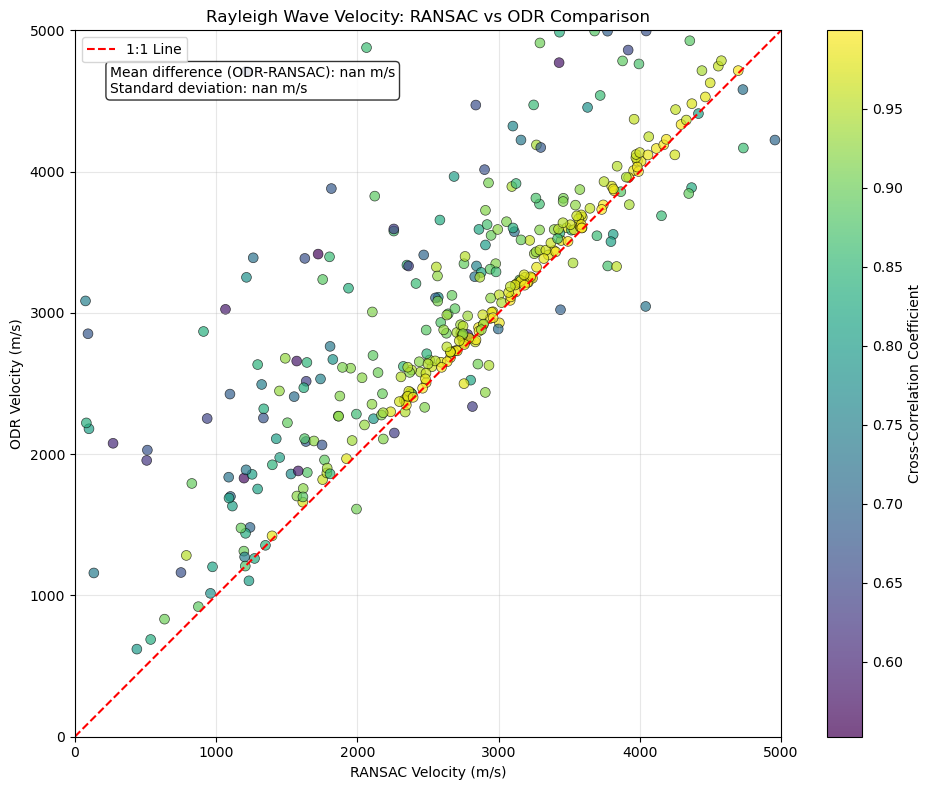

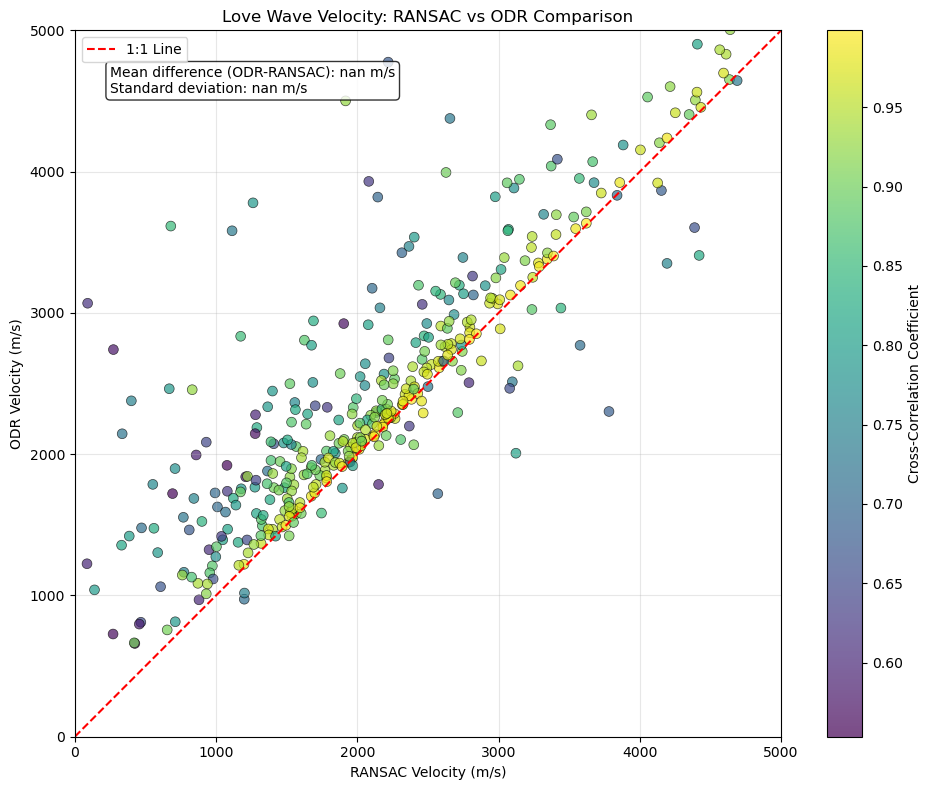

In [ ]:
def plot_velocity_comparison(ransac_results, odr_results, wave_type='Rayleigh', vmax=5000):
    """
    Create a scatter plot comparing velocities from RANSAC and ODR methods.
    
    Parameters:
    -----------
    ransac_results : dict
        Results dictionary from compute_velocities with method='ransac'
    odr_results : dict
        Results dictionary from compute_velocities with method='odr'
    wave_type : str
        Type of wave ('Rayleigh' or 'Love') for the plot title
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object containing the plot
    """
    # Extract velocities
    ransac_vel = ransac_results['velocity']
    odr_vel = odr_results['velocity']
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create scatter plot
    sc = ax.scatter(ransac_vel, odr_vel, 
                   c=ransac_results['ccoef'], cmap='viridis', 
                   alpha=0.7, s=50, edgecolor='k', linewidth=0.5)
    
    # Add colorbar
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Cross-Correlation Coefficient')
    
    # Add identity line
    vals = np.linspace(0, 10_000, 100)
    ax.plot(vals, vals, 'r--', label='1:1 Line')
    
    ax.set_xlim(0, vmax)
    ax.set_ylim(0, vmax)

    # Add labels and title
    ax.set_xlabel('RANSAC Velocity (m/s)')
    ax.set_ylabel('ODR Velocity (m/s)')
    ax.set_title(f'{wave_type} Wave Velocity: RANSAC vs ODR Comparison')
    
    # Add grid and legend
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Set equal aspect ratio
    ax.set_aspect('equal')
    
    # Add statistics
    diff = np.array(odr_vel) - np.array(ransac_vel)
    mean_diff = np.mean(diff)
    std_diff = np.std(diff)
    
    stats_text = f"Mean difference (ODR-RANSAC): {mean_diff:.2f} m/s\n"
    stats_text += f"Standard deviation: {std_diff:.2f} m/s"
    
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return fig

# Example usage:
fig = plot_velocity_comparison(rayleigh_velocities_ransac, rayleigh_velocities_odr, wave_type='Rayleigh')

# You can also do the same for Love waves:
fig = plot_velocity_comparison(love_velocities_ransac, love_velocities_odr, wave_type='Love')


### Test optimization of parameters with frequency and backazimuth in time windows

For Love waves:

/home/andbro/cursorfiles/sixdegrees/sixdegrees.py:3392: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



Optimal Parameters (v ≤ {vel_max_threshold} m/s):
Mean Velocity: 451.4 m/s
Mean Backazimuth: 239.1°
Mean Cross-correlation: 0.841
Number of points: 32 / 42


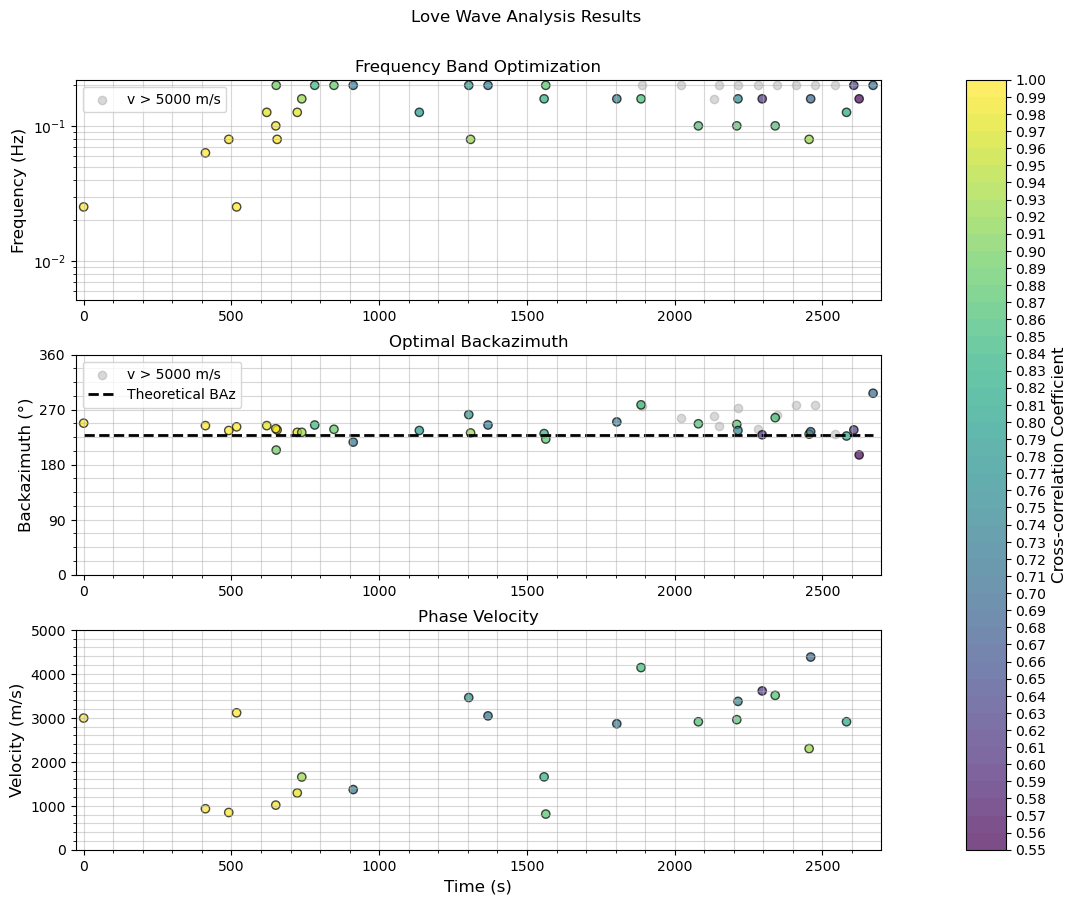

In [ ]:
# Get optimization results
params = sd.optimize_parameters(wave_type='love', 
                              fbands={'fmin': 0.01, 'fmax': 0.2, 'octave_fraction': 6}, 
                              baz_step=config['baz_step'],
                              twin_min=config['twin_sec'],
                              overlap=0.5,
                              bandwidth_factor=6)

# Plot results using the class method
fig = sd.plot_optimization_results(params, wave_type='love',
                                   vel_max_threshold=5000,
                                   cc_threshold=config['cc_threshold'],
                                   baz_theo=ev['backazimuth'])
plt.show()

For Rayleigh waves:


Optimal Parameters (v ≤ {vel_max_threshold} m/s):
Mean Velocity: 3983.3 m/s
Mean Backazimuth: 209.5°
Mean Cross-correlation: 0.989
Number of points: 2 / 21


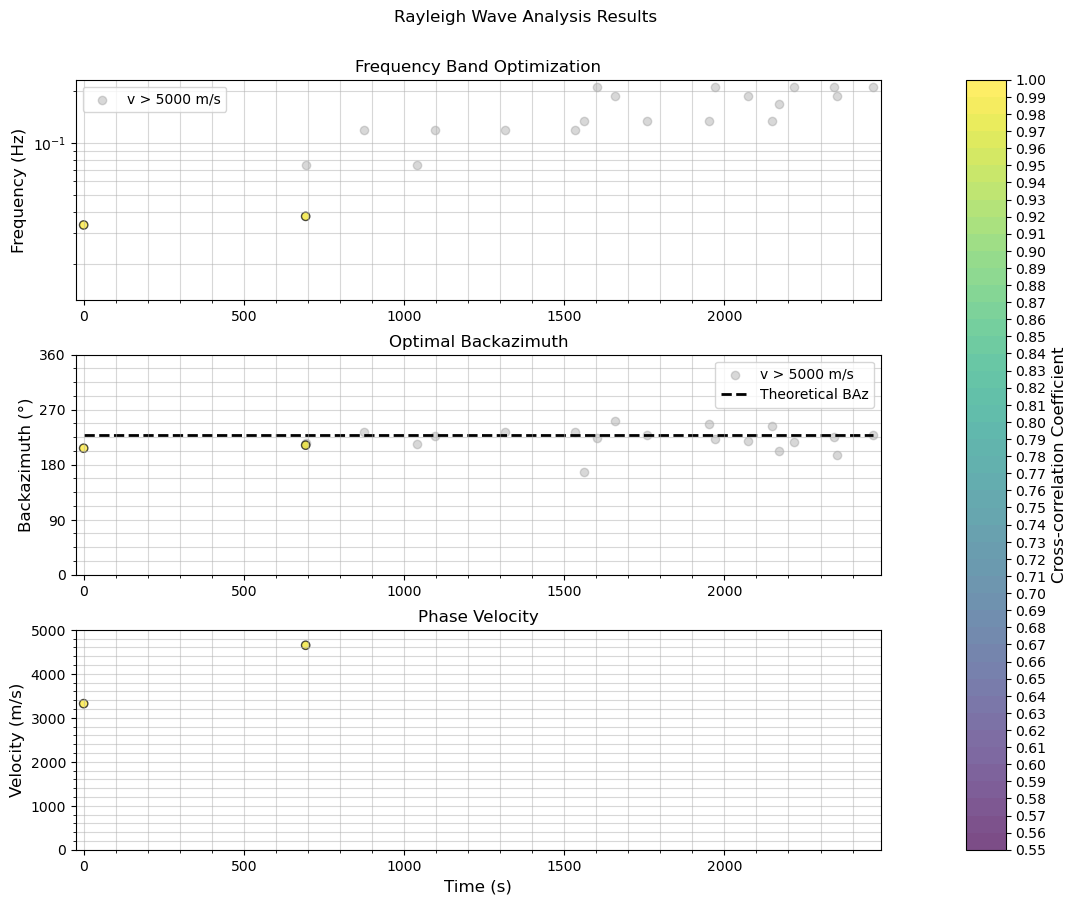

In [ ]:
# Get optimization results
params = sd.optimize_parameters(wave_type='rayleigh', 
                              fbands={'fmin': 0.01, 'fmax': 0.2, 'octave_fraction': 6}, 
                              baz_step=config['baz_step'],
                              twin_min=config['twin_sec'],
                              overlap=0.5,
                              bandwidth_factor=6)

# Plot results using the class method
fig = sd.plot_optimization_results(params, wave_type='rayleigh',
                                   vel_max_threshold=5000,
                                   cc_threshold=config['cc_threshold'],
                                   baz_theo=ev['backazimuth'])
plt.show()